In [ ]:
!pip install pycocotools


In [ ]:

!kaggle datasets download -d awsaf49/coco-2017-dataset -p /content/drive/My\ Drive/COMP9444_project/
!unzip /content/drive/MyDrive/COMP9444_project/coco-2017-dataset.zip -d /content/drive/MyDrive/COMP9444_project/data


coco-2017-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/COMP9444_project/coco-2017-dataset.zip
replace /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_train2017.json  
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/captions_val2017.json  
  inflating: /content/drive/MyDrive/COMP9444_project/data/coco2017/annotations/instances_train2017.json  

In [1]:
BASE_PATH= '/content/drive/MyDrive/COMP9444_project/data/coco2017'

!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/COMP9444_project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


设置路径

In [18]:
from typing import Annotated
from pycocotools.coco import COCO

train_img_file=os.path.join(BASE_PATH,'train2017')
test_img_file=os.path.join(BASE_PATH,'test2017')
val_img_file=os.path.join(BASE_PATH,'val2017')

anno_file=os.path.join(BASE_PATH,'annotations')
train_file=os.path.join(anno_file,'captions_train2017.json')
val_file=os.path.join(anno_file,'captions_val2017.json')


cat_val_file=os.path.join(anno_file,'instances_val2017.json')

In [4]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qt4t1nls
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qt4t1nls
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=1f0d6f67de59f58bceabc7009e45ba8669bc62a139bcbddb2478c602320c7121
  Stored in directory: /tmp/pip-ephem-wheel-cache-0snlv3zr/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [19]:
coco_train=COCO(train_file)
coco_val=COCO(val_file)


coco_cat_val=COCO(cat_val_file)

loading annotations into memory...
Done (t=2.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


加载图片id和信息

In [22]:
train_img_id=coco_train.getImgIds()
train_img_info=coco_train.loadImgs(train_img_id)
val_img_id=coco_val.getImgIds()
val_img_info=coco_val.loadImgs(val_img_id)


#加载类别id
cat_Ids=coco_cat_val.getCatIds()
print(cat_Ids)
#加载类别信息
cat_1=coco_cat_val.loadCats(cat_Ids[0])
print(cat_1)
#加载该类图片ID
imgid_cat_1=coco_cat_val.getImgIds(catIds=1)
print(imgid_cat_1[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
[{'supercategory': 'person', 'id': 1, 'name': 'person'}]
532481


图片地址和注释

In [ ]:
def load_data(val=False,part=0):
  data_list=[]
  if val:
    ids=val_img_id
    data=coco_val
    file=val_img_file

  else:
    ids=train_img_id
    data=coco_train
    file=train_img_file

  if part>0:
    num=len(ids) // part
    ids=random.sample(ids,num)
  print(ids[0])
  for id in ids:
    annid=data.getAnnIds(id)
    anns=data.loadAnns(annid)
    caption=[ann['caption'] for ann in anns]
    img_path=os.path.join(file,"{:012d}.jpg".format(id))
    data_list.append([img_path,caption])



  return data_list

In [ ]:
data_list=load_data(True,5)
len(data_list)

212559


1000

id打印注释和图片


In [ ]:
def show_img(id,val=False):
  if val:
    data=coco_val
    file=val_img_file
  else:
    data=coco_train
    file=train_img_file

  annid=data.getAnnIds(id)
  anns=data.loadAnns(annid)
  data.showAnns(anns)
  img_path=os.path.join(file,"{:012d}.jpg".format(id))
  pic=cv2.imread(img_path)
  plt.imshow(pic)
  plt.axis('off')
  plt.show()

In [ ]:
show_img(train_img_id[0])

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


KeyboardInterrupt: ignored

In [ ]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, CenterCrop, ToTensor, Normalize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        RandomHorizontalFlip(0.2),
        RandomVerticalFlip(0.1),
        ColorJitter(0.5,0.5,0.5),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
def _R1(n_px):
  return Compose([
        RandomHorizontalFlip(0.2),
        RandomVerticalFlip(0.1),
        ColorJitter(0.5,0.5,0.5),
        ToTensor(),
    ])

In [ ]:
train_img_id[0]

391895

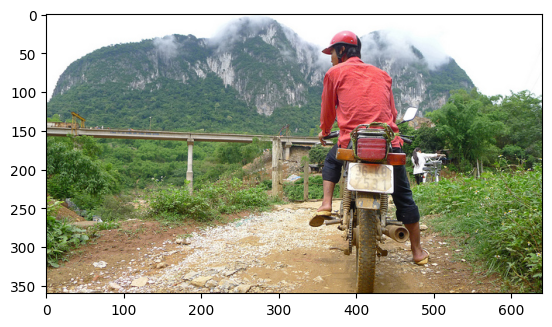

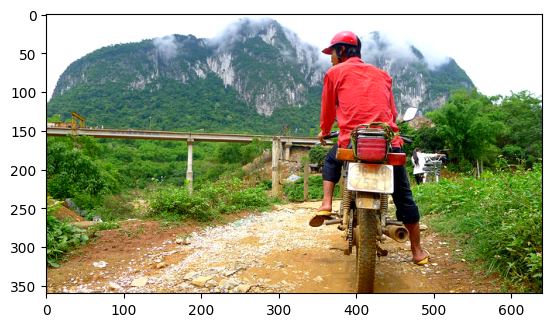

In [ ]:
import clip
import torch
import skimage.io as io
import clip
import matplotlib.pyplot as plt
import pickle
import json
import os
from tqdm import tqdm
import argparse
import time  # Import the time module to measure elapsed time
from PIL import Image
from torchvision.transforms import ToPILImage
clip_model_type="ViT-B/32"
device = torch.device('cuda:0')
filename=os.path.join(train_img_file,"{:012d}.jpg".format(train_img_id[0]))
image=io.imread(filename)
plt.imshow(image)
plt.show()
preprocess = _R1(224)
image = io.imread(filename)
image = preprocess(Image.fromarray(image)).unsqueeze(0)
image = image.squeeze(0)
unloader =ToPILImage()
image=unloader(image)
plt.imshow(image)
plt.show()